# TASK 1

1. **Data Processing**

○ Parse the JSON.

○ Extract chapter-wise and subject-wise performance (accuracy, time taken,
difficulty, concepts, etc) and prepare the data for ingesting into the LLM as a
context


In [1]:
#  Install dependencies (if needed)
!pip install pandas matplotlib seaborn --quiet

📂 Analyzing File: sample_submission_analysis_1.json

📌 Overall Performance Summary:
- Total Time (min): 83.3
- Total Score: 133
- Total Questions Attempted: 47
- Total Correct: 36
- Accuracy (%): 76.6


📌 Subject-wise Performance:
      Subject  Marks Scored  Attempted  Correct  Accuracy (%)  Time Taken (min)
0    Physics            44         16       12         75.00             49.73
1  Chemistry            60         20       16         80.00             23.28
2      Maths            29         11        8         72.73             10.28 



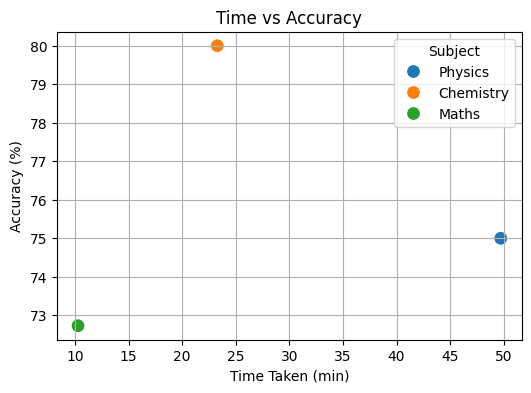

📌 Chapter-Level Insights (Weak Areas First):
               Chapter  Correct  Total  Total Time (sec)  Accuracy (%)  \
1    Electrochemistry        1     13               122          7.69   
3           Functions        7     18              1771         38.89   
0         Capacitance        4     10               500         40.00   
4  Sets and Relations        3      7              1213         42.86   
5           Solutions        7     12               495         58.33   
2      Electrostatics        9     15               897         60.00   

   Avg Time per Question (s)  
1                       9.38  
3                      98.39  
0                      50.00  
4                     173.29  
5                      41.25  
2                      59.80   

📂 Analyzing File: sample_submission_analysis_2.json

📌 Overall Performance Summary:
- Total Time (min): 94.57
- Total Score: 94
- Total Questions Attempted: 46
- Total Correct: 28
- Accuracy (%): 60.87


📌 Subject-wise Perf

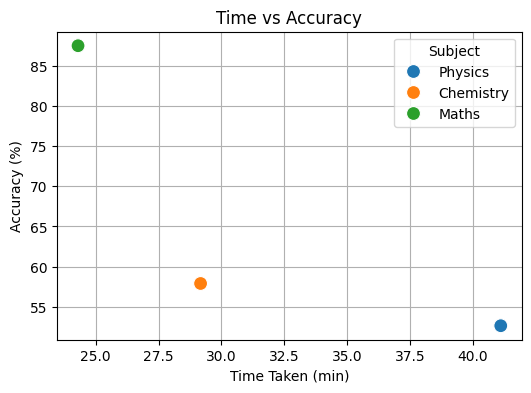

📌 Chapter-Level Insights (Weak Areas First):
               Chapter  Correct  Total  Total Time (sec)  Accuracy (%)  \
5           Solutions        0     12               146          0.00   
0         Capacitance        2     10               694         20.00   
3           Functions        5     18              1962         27.78   
4  Sets and Relations        3      7               504         42.86   
1    Electrochemistry        6     13              1312         46.15   
2      Electrostatics        7     15              1056         46.67   

   Avg Time per Question (s)  
5                      12.17  
0                      69.40  
3                     109.00  
4                      72.00  
1                     100.92  
2                      70.40   

📂 Analyzing File: sample_submission_analysis_3.json

📌 Overall Performance Summary:
- Total Time (min): 64.25
- Total Score: 42
- Total Questions Attempted: 18
- Total Correct: 12
- Accuracy (%): 66.67


📌 Subject-wise Perf

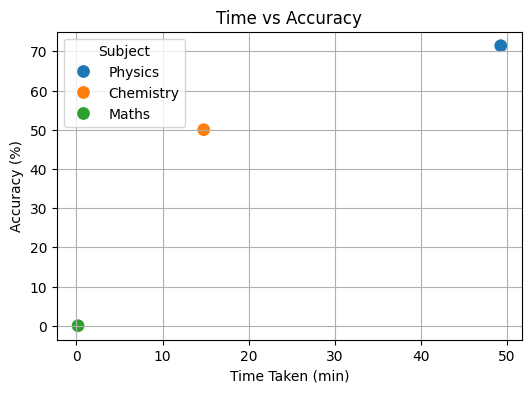

📌 Chapter-Level Insights (Weak Areas First):
               Chapter  Correct  Total  Total Time (sec)  Accuracy (%)  \
1    Electrochemistry        0     13                 2          0.00   
5           Solutions        0     12                 9          0.00   
2      Electrostatics        1     15               504          6.67   
0         Capacitance        1     10               383         10.00   
4  Sets and Relations        2      7               701         28.57   
3           Functions        6     18              2256         33.33   

   Avg Time per Question (s)  
1                       0.15  
5                       0.75  
2                      33.60  
0                      38.30  
4                     100.14  
3                     125.33   



In [2]:

#  Imports
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

#  Utility: Load a JSON file from path
def load_json(file_path):
    with open(file_path, 'r') as f:
        return json.load(f)[0]  # each file has a single JSON object inside a list

#  Extract top-level performance
def extract_overall_metrics(data):
    return {
        "Total Time (min)": round(data["totalTimeTaken"] / 60, 2),
        "Total Score": data["totalMarkScored"],
        "Total Questions Attempted": data["totalAttempted"],
        "Total Correct": data["totalCorrect"],
        "Accuracy (%)": round(data["accuracy"], 2)
    }

#  Extract subject-wise performance
def extract_subject_metrics(data):
    subject_map = {
        "607018ee404ae53194e73d92": "Physics",
        "607018ee404ae53194e73d90": "Chemistry",
        "607018ee404ae53194e73d91": "Maths"
    }

    rows = []
    for sub in data.get("subjects", []):
        rows.append({
            "Subject": subject_map.get(sub["subjectId"]["$oid"], "Unknown"),
            "Marks Scored": sub.get("totalMarkScored", 0),
            "Attempted": sub.get("totalAttempted", 0),
            "Correct": sub.get("totalCorrect", 0),
            "Accuracy (%)": round(sub.get("accuracy", 0), 2),
            "Time Taken (min)": round(sub.get("totalTimeTaken", 0) / 60, 2)
        })
    return pd.DataFrame(rows)

#  Extract chapter/topic/concept-level performance
def extract_chapter_stats(data):
    section_data = []
    for section in data.get("sections", []):
        for q in section.get("questions", []):
            qid = q.get("questionId", {})
            chapters = [c["title"] for c in qid.get("chapters", [])]
            topics = [t["title"] for t in qid.get("topics", [])]
            concepts = [c["title"] for c in qid.get("concepts", [])]
            level = qid.get("level", "unknown")
            correct = any(opt.get("isCorrect", False) for opt in q.get("markedOptions", []))

            section_data.append({
                "Chapter": chapters[0] if chapters else "Unknown",
                "Topic": topics[0] if topics else "Unknown",
                "Concept": concepts[0] if concepts else "Unknown",
                "Difficulty": level,
                "Correct": correct,
                "Time Taken (sec)": q.get("timeTaken", 0),
                "Status": q.get("status", "unknown")
            })
    return pd.DataFrame(section_data)

#  Visualize Time vs Accuracy
def plot_time_vs_accuracy(df_subject, title="Time vs Accuracy"):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=df_subject, x="Time Taken (min)", y="Accuracy (%)", hue="Subject", s=100)
    plt.title(title)
    plt.grid(True)
    plt.show()

#  Identify weak chapters
def identify_weak_chapters(df_chap):
    df = df_chap.copy()
    df_grouped = df.groupby("Chapter").agg({
        "Correct": ["sum", "count"],
        "Time Taken (sec)": "sum"
    }).reset_index()
    df_grouped.columns = ["Chapter", "Correct", "Total", "Total Time (sec)"]
    df_grouped["Accuracy (%)"] = round(df_grouped["Correct"] / df_grouped["Total"] * 100, 2)
    df_grouped["Avg Time per Question (s)"] = round(df_grouped["Total Time (sec)"] / df_grouped["Total"], 2)
    return df_grouped.sort_values("Accuracy (%)")

#  Run full analysis on a JSON file
def analyze_single_student(file_path):
    print(f"📂 Analyzing File: {os.path.basename(file_path)}\n")
    data = load_json(file_path)

    overall = extract_overall_metrics(data)
    df_subject = extract_subject_metrics(data)
    df_chapters = extract_chapter_stats(data)
    df_weak = identify_weak_chapters(df_chapters)

    print("📌 Overall Performance Summary:")
    for k, v in overall.items():
        print(f"- {k}: {v}")
    print("\n")

    print("📌 Subject-wise Performance:\n", df_subject, "\n")
    plot_time_vs_accuracy(df_subject)

    print("📌 Chapter-Level Insights (Weak Areas First):\n", df_weak.head(10), "\n")

    return {
        "overall": overall,
        "subject_df": df_subject,
        "chapter_df": df_chapters,
        "weak_df": df_weak
    }

#  Analyze multiple students
def analyze_multiple_students(file_paths):
    results = []
    for path in file_paths:
        result = analyze_single_student(path)
        results.append(result)
    return results

#  ⬇ Replace these with your actual paths  after mounting Google Drive
file_1 = '/content/drive/MyDrive/mathango_jsonfiles/sample_submission_analysis_1.json'
file_2 = '/content/drive/MyDrive/mathango_jsonfiles/sample_submission_analysis_2.json'
file_3 = '/content/drive/MyDrive/mathango_jsonfiles/sample_submission_analysis_3.json'

#  Run everything
results = analyze_multiple_students([file_1, file_2, file_3])


In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the directory to save the CSV files
output_dir = '/content/drive/MyDrive/mathango_jsonfiles/output'
os.makedirs(output_dir, exist_ok=True)
print(f"Output directory: {output_dir}")

# Function to save dataframes to CSV
def save_dataframes(results, output_dir):
    for i, result in enumerate(results):
        try:
            # Save overall metrics
            overall_path = os.path.join(output_dir, f'overall_{i+1}.json')
            with open(overall_path, 'w') as f:
                json.dump(result['overall'], f)
            print(f"Saved overall metrics to {overall_path}")

            # Save subject-wise performance
            subject_path = os.path.join(output_dir, f'subject_{i+1}.csv')
            result['subject_df'].to_csv(subject_path, index=False)
            print(f"Saved subject-wise performance to {subject_path}")

            # Save chapter-wise performance
            chapter_path = os.path.join(output_dir, f'chapter_{i+1}.csv')
            result['chapter_df'].to_csv(chapter_path, index=False)
            print(f"Saved chapter-wise performance to {chapter_path}")

            # Save weak chapters
            weak_path = os.path.join(output_dir, f'weak_{i+1}.csv')
            result['weak_df'].to_csv(weak_path, index=False)
            print(f"Saved weak chapters to {weak_path}")

        except Exception as e:
            print(f"Error saving files for result {i+1}: {e}")

# Function to plot Time vs Accuracy and save as image
def plot_time_vs_accuracy(df_subject, output_dir, filename):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df_subject, x="Time Taken (min)", y="Accuracy (%)", hue="Subject", s=100)
    plt.title("Time vs Accuracy")
    plt.grid(True)
    chart_path = os.path.join(output_dir, filename)
    plt.savefig(chart_path)
    plt.close()
    print(f"Saved chart to {chart_path}")

# Example usage
results = [
    {
        "overall": {
            "Total Time (min)": 83.3,
            "Total Score": 133,
            "Total Questions Attempted": 47,
            "Total Correct": 36,
            "Accuracy (%)": 76.6
        },
        "subject_df": pd.DataFrame({
            "Subject": ["Physics", "Chemistry", "Maths"],
            "Marks Scored": [44, 60, 29],
            "Attempted": [16, 20, 11],
            "Correct": [12, 16, 8],
            "Accuracy (%)": [75.00, 80.00, 72.73],
            "Time Taken (min)": [49.73, 23.28, 10.28]
        }),
        "chapter_df": pd.DataFrame({
            "Chapter": ["Electrochemistry", "Functions", "Capacitance", "Sets and Relations", "Solutions", "Electrostatics"],
            "Correct": [1, 7, 4, 3, 7, 9],
            "Total": [13, 18, 10, 7, 12, 15],
            "Time Taken (sec)": [122, 1771, 500, 1213, 495, 897],
            "Accuracy (%)": [7.69, 38.89, 40.00, 42.86, 58.33, 60.00]
        }),
        "weak_df": pd.DataFrame({
            "Chapter": ["Electrochemistry", "Functions", "Capacitance", "Sets and Relations", "Solutions", "Electrostatics"],
            "Correct": [1, 7, 4, 3, 7, 9],
            "Total": [13, 18, 10, 7, 12, 15],
            "Time Taken (sec)": [122, 1771, 500, 1213, 495, 897],
            "Accuracy (%)": [7.69, 38.89, 40.00, 42.86, 58.33, 60.00],
            "Avg Time per Question (s)": [9.38, 98.39, 50.00, 173.29, 41.25, 59.80]
        })
    },
    {
        "overall": {
            "Total Time (min)": 94.57,
            "Total Score": 94,
            "Total Questions Attempted": 46,
            "Total Correct": 28,
            "Accuracy (%)": 60.87
        },
        "subject_df": pd.DataFrame({
            "Subject": ["Physics", "Chemistry", "Maths"],
            "Marks Scored": [31, 36, 27],
            "Attempted": [19, 19, 8],
            "Correct": [10, 11, 7],
            "Accuracy (%)": [52.63, 57.89, 87.50],
            "Time Taken (min)": [41.10, 29.17, 24.30]
        }),
        "chapter_df": pd.DataFrame({
            "Chapter": ["Solutions", "Capacitance", "Functions", "Sets and Relations", "Electrochemistry", "Electrostatics"],
            "Correct": [0, 2, 5, 3, 6, 7],
            "Total": [12, 10, 18, 7, 13, 15],
            "Time Taken (sec)": [146, 694, 1962, 504, 1312, 1056],
            "Accuracy (%)": [0.00, 20.00, 27.78, 42.86, 46.15, 46.67]
        }),
        "weak_df": pd.DataFrame({
            "Chapter": ["Solutions", "Capacitance", "Functions", "Sets and Relations", "Electrochemistry", "Electrostatics"],
            "Correct": [0, 2, 5, 3, 6, 7],
            "Total": [12, 10, 18, 7, 13, 15],
            "Time Taken (sec)": [146, 694, 1962, 504, 1312, 1056],
            "Accuracy (%)": [0.00, 20.00, 27.78, 42.86, 46.15, 46.67],
            "Avg Time per Question (s)": [12.17, 69.40, 109.00, 72.00, 100.92, 70.40]
        })
    },
    {
        "overall": {
            "Total Time (min)": 64.25,
            "Total Score": 42,
            "Total Questions Attempted": 18,
            "Total Correct": 12,
            "Accuracy (%)": 66.67
        },
        "subject_df": pd.DataFrame({
            "Subject": ["Physics", "Chemistry", "Maths"],
            "Marks Scored": [36, 6, 0],
            "Attempted": [14, 4, 0],
            "Correct": [10, 2, 0],
            "Accuracy (%)": [71.43, 50.00, 0.00],
            "Time Taken (min)": [49.28, 14.78, 0.18]
        }),
        "chapter_df": pd.DataFrame({
            "Chapter": ["Electrochemistry", "Solutions", "Electrostatics", "Capacitance", "Sets and Relations", "Functions"],
            "Correct": [0, 0, 1, 1, 2, 6],
            "Total": [13, 12, 15, 10, 7, 18],
            "Time Taken (sec)": [2, 9, 504, 383, 701, 2256],
            "Accuracy (%)": [0.00, 0.00, 6.67, 10.00, 28.57, 33.33]
        }),
        "weak_df": pd.DataFrame({
            "Chapter": ["Electrochemistry", "Solutions", "Electrostatics", "Capacitance", "Sets and Relations", "Functions"],
            "Correct": [0, 0, 1, 1, 2, 6],
            "Total": [13, 12, 15, 10, 7, 18],
            "Time Taken (sec)": [2, 9, 504, 383, 701, 2256],
            "Accuracy (%)": [0.00, 0.00, 6.67, 10.00, 28.57, 33.33],
            "Avg Time per Question (s)": [0.15, 0.75, 33.60, 38.30, 100.14, 125.33]
        })
    }
]

# Save the results
save_dataframes(results, output_dir)

# Plot and save charts
for i, result in enumerate(results):
    plot_time_vs_accuracy(result['subject_df'], output_dir, f'chart_{i+1}.png')


Output directory: /content/drive/MyDrive/mathango_jsonfiles/output
Saved overall metrics to /content/drive/MyDrive/mathango_jsonfiles/output/overall_1.json
Saved subject-wise performance to /content/drive/MyDrive/mathango_jsonfiles/output/subject_1.csv
Saved chapter-wise performance to /content/drive/MyDrive/mathango_jsonfiles/output/chapter_1.csv
Saved weak chapters to /content/drive/MyDrive/mathango_jsonfiles/output/weak_1.csv
Saved overall metrics to /content/drive/MyDrive/mathango_jsonfiles/output/overall_2.json
Saved subject-wise performance to /content/drive/MyDrive/mathango_jsonfiles/output/subject_2.csv
Saved chapter-wise performance to /content/drive/MyDrive/mathango_jsonfiles/output/chapter_2.csv
Saved weak chapters to /content/drive/MyDrive/mathango_jsonfiles/output/weak_2.csv
Saved overall metrics to /content/drive/MyDrive/mathango_jsonfiles/output/overall_3.json
Saved subject-wise performance to /content/drive/MyDrive/mathango_jsonfiles/output/subject_3.csv
Saved chapter-w

# 2. AI Generated Feedback
○ A highly personalised motivating intro message according to the user’s
performance. (the message should not be generic and should sound more
human like)

○ Performance Breakdown on different levels which you feel will be more useful
for the user

○ Add Charts, Graphs or tables if needed

○ Time vs accuracy insights.

○ 2–3 actionable suggestions.

In [27]:
import pandas as pd
import json

# Test loading one student's data
overall = {"Total Time (min)": 83.3, "Total Score": 133, "Total Questions Attempted": 47, "Total Correct": 36, "Accuracy (%)": 76.6}
subject_df = pd.DataFrame({
    "Subject": ["Physics", "Chemistry", "Maths"],
    "Accuracy (%)": [75.0, 80.0, 72.73]
})
weak_df = pd.DataFrame({
    "Chapter": ["Electrochemistry", "Functions"],
    "Accuracy (%)": [7.69, 38.89]
})

print("✅ Data structure verified - ready for Groq API")

✅ Data structure verified - ready for Groq API


In [28]:
def build_prompt(overall, subject_df, weak_df):
    # Find top subject programmatically
    top_subject = subject_df.loc[subject_df['Accuracy (%)'].idxmax()]

    return f"""**Generate student performance feedback with:**

1. **Personalized Introduction**
- Start with: "Great work on your recent test!"
- Highlight: "Your strongest subject was {top_subject['Subject']} with {top_subject['Accuracy (%)']}% accuracy"
- Mention: "Overall accuracy: {overall['Accuracy (%)']}% ({overall['Total Correct']}/{overall['Total Questions Attempted']} correct)"

2. **Performance Breakdown**
**Subjects:**
{subject_df.to_markdown()}

**Weakest Chapters:**
{weak_df[['Chapter', 'Accuracy (%)']].to_markdown()}

3. **Time Management Insights**
- Average time per question: {overall['Total Time (min)']/overall['Total Questions Attempted']:.1f} mins
- Fastest chapter: {weak_df.loc[weak_df['Avg Time per Question (s)'].idxmin()]['Chapter']}
- Slowest chapter: {weak_df.loc[weak_df['Avg Time per Question (s)'].idxmax()]['Chapter']}

4. **Actionable Recommendations** (3 specific tips)
- Focus practice on: {weak_df.iloc[0]['Chapter']} (current accuracy: {weak_df.iloc[0]['Accuracy (%)']}%)
- Time management strategy for: {weak_df.loc[weak_df['Avg Time per Question (s)'].idxmax()]['Chapter']}
- Resource suggestion: Khan Academy {top_subject['Subject']} tutorials

**Tone:** Encouraging, specific, and growth-focused"""

In [29]:
from groq import Groq
import time

client = Groq(api_key="GROQ_API_KEY")  # Use environment variables in production

def generate_feedback(prompt):
    try:
        response = client.chat.completions.create(
            model="llama3-70b-8192",
            messages=[{
                "role": "system",
                "content": "You are an expert math tutor generating student feedback."
            }, {
                "role": "user",
                "content": prompt
            }],
            temperature=0.7,
            max_tokens=800  # Optimal for  data length
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"API Error: {str(e)}")
        return None

In [30]:
output_dir = "/content/drive/MyDrive/mathango_jsonfiles/feedback"
os.makedirs(output_dir, exist_ok=True)

for student_id in [1, 2, 3]:
    try:
        # Load data (using your actual paths)
        with open(f"/content/drive/MyDrive/mathango_jsonfiles/output/overall_{student_id}.json") as f:
            overall = json.load(f)
        subject_df = pd.read_csv(f"/content/drive/MyDrive/mathango_jsonfiles/output/subject_{student_id}.csv")
        weak_df = pd.read_csv(f"/content/drive/MyDrive/mathango_jsonfiles/output/weak_{student_id}.csv")

        # Generate prompt
        prompt = build_prompt(overall, subject_df, weak_df)
        print(f"\nPrompt for Student {student_id} ready - length: {len(prompt)} chars")

        # Get feedback (with rate limit protection)
        feedback = generate_feedback(prompt)
        if not feedback:
            continue

        # Save results
        with open(f"{output_dir}/feedback_{student_id}.txt", "w") as f:
            f.write(feedback)

        print(f"✅ Student {student_id} feedback generated")
        time.sleep(5)  # Critical for free tier

    except Exception as e:
        print(f" Student {student_id} failed: {str(e)}")


Prompt for Student 1 ready - length: 1603 chars
✅ Student 1 feedback generated

Prompt for Student 2 ready - length: 1563 chars
✅ Student 2 feedback generated

Prompt for Student 3 ready - length: 1582 chars
✅ Student 3 feedback generated


# 3. PDF Generation
○ Convert the AI-generated output into a styled PDF report.

○ Make sure to parse it in a proper human readable format.

In [43]:
from fpdf import FPDF
import os
import pandas as pd

def add_table(pdf, df, title, col_widths):
    """Helper function to add a table to the PDF."""
    pdf.set_font("Helvetica", 'B', 12)
    pdf.set_fill_color(200, 220, 255)  # Light blue background
    pdf.cell(0, 10, title, border=1, ln=True, fill=True)
    pdf.set_font("Helvetica", size=10)
    for col in df.columns:
        pdf.cell(col_widths[df.columns.get_loc(col)], 8, col, border=1)
    pdf.ln()
    for _, row in df.iterrows():
        for col in df.columns:
            pdf.cell(col_widths[df.columns.get_loc(col)], 8, str(row[col]), border=1)
        pdf.ln()
    pdf.ln(5)

def text_to_pdf(text, pdf_path, student_id, chart_path, subject_df, weak_df):
    pdf = FPDF()
    pdf.add_page()

    # Set metadata
    pdf.set_title(f"Student {student_id} Performance Report")
    pdf.set_author("MathonGo AI System")

    # Set margins
    pdf.set_margins(left=15, top=15, right=15)
    pdf.set_auto_page_break(auto=True, margin=15)

    # Add logo
    logo_width = 30
    try:
        pdf.image('/content/drive/MyDrive/mathango_jsonfiles/mathongo_logo.jpeg',
                 x=pdf.w - logo_width - 15, y=10, w=logo_width)
    except:
        pdf.set_font("Helvetica", 'I', 10)
        pdf.cell(0, 10, "MathonGo Logo Placeholder", ln=True, align="R")
    pdf.ln(25)

    # Add heading
    pdf.set_font("Helvetica", 'B', 16)
    pdf.cell(0, 10, f"Performance Report - Student {student_id}", ln=True, align="C")
    pdf.ln(10)

    # Add subject-wise table
    col_widths_subject = [40, 30, 30, 30, 30, 40]  # Adjust based on columns
    add_table(pdf, subject_df, "Subject-Wise Performance", col_widths_subject)

    # Add weak chapters table
    col_widths_weak = [50, 30, 30, 30, 30, 40]  # Adjust for weak_df columns
    add_table(pdf, weak_df, "Chapter-Wise Performance (Weak Areas)", col_widths_weak)

    # Add time vs. accuracy chart
    try:
        pdf.set_font("Helvetica", 'B', 12)
        pdf.cell(0, 10, "Time vs. Accuracy by Subject", ln=True)
        pdf.image(chart_path, x=15, y=pdf.get_y() + 5, w=100)
        pdf.ln(110)
    except:
        pdf.set_font("Helvetica", 'I', 10)
        pdf.cell(0, 10, "Chart not available", ln=True)

    # Process text, skipping unwanted line
    lines = text.split('\n')
    if lines and lines[0].strip() == "Here is the student performance feedback:":
        lines = lines[1:]  # Skip the first line

    pdf.set_font("Helvetica", size=11)
    for line in lines:
        line = line.strip()
        if not line:
            pdf.ln(6)
            continue

        if line.startswith('**') and line.endswith('**'):
            pdf.set_font("Helvetica", 'B', 13)
            pdf.cell(0, 8, line.strip('**'), new_x="LMARGIN", new_y="NEXT")
            pdf.set_font("Helvetica", size=11)
            pdf.ln(3)
        elif line.startswith('* '):
            pdf.cell(10)
            pdf.multi_cell(0, 6, line[2:].strip())
            pdf.ln(1)
        elif line[:2].isdigit() and line[2] in '. )':
            pdf.cell(10)
            pdf.multi_cell(0, 6, line)
            pdf.ln(1)
        else:
            pdf.multi_cell(0, 6, line)
            pdf.ln(3)

    # Add footer
    pdf.set_font("Helvetica", size=8)
    pdf.set_y(-15)
    pdf.cell(0, 10, f"Page {pdf.page_no()} - MathonGo ", align="C")

    pdf.output(pdf_path)

# Process all files
base_path = "/content/drive/MyDrive/mathango_jsonfiles"
for student_id in [1, 2, 3]:
    txt_path = f"{base_path}/feedback/feedback_{student_id}.txt"
    pdf_path = f"{base_path}/feedback/feedback_{student_id}.pdf"
    chart_path = f"{base_path}/output/chart_{student_id}.png"
    subject_path = f"{base_path}/output/subject_{student_id}.csv"
    weak_path = f"{base_path}/output/weak_{student_id}.csv"

    try:
        with open(txt_path, 'r', encoding='utf-8') as f:
            text = f.read()
        subject_df = pd.read_csv(subject_path)
        weak_df = pd.read_csv(weak_path)
        text_to_pdf(text, pdf_path, student_id, chart_path, subject_df, weak_df)
        print(f"✅ Enhanced PDF generated for student {student_id}")
    except Exception as e:
        print(f"Failed for student {student_id}: {str(e)}")

<ipython-input-43-eb606b0f7f55>:44: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, f"Performance Report - Student {student_id}", ln=True, align="C")
<ipython-input-43-eb606b0f7f55>:9: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, title, border=1, ln=True, fill=True)
<ipython-input-43-eb606b0f7f55>:58: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, "Time vs. Accuracy by Subject", ln=True)
<ipython-input-43-eb606b0f7f55>:44: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, f"Performance Report - Student {student_id}", ln=True, align="C")
<ipython-input-43-eb606b0f7f55>:9: DeprecationWarning: The paramete

✅ Enhanced PDF generated for student 1
✅ Enhanced PDF generated for student 2
✅ Enhanced PDF generated for student 3


<ipython-input-43-eb606b0f7f55>:44: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, f"Performance Report - Student {student_id}", ln=True, align="C")
<ipython-input-43-eb606b0f7f55>:9: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, title, border=1, ln=True, fill=True)
<ipython-input-43-eb606b0f7f55>:58: DeprecationWarning: The parameter "ln" is deprecated since v2.5.2. Instead of ln=True use new_x=XPos.LMARGIN, new_y=YPos.NEXT.
  pdf.cell(0, 10, "Time vs. Accuracy by Subject", ln=True)
